# Day 39 · 信贷数据集神经网络训练

本篇以博客形式记录完整流程：从原始信贷数据的预处理，到使用 PyTorch 构建多层感知机，并同时观察训练集与测试集在每个 epoch 上的损失与准确率曲线。

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import warnings
import random

warnings.filterwarnings('ignore')  # 忽略警告信息

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

data=pd.read_csv('../data.csv')
data.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


## 数据预处理（与原 Notebook 保持一致）
以下代码沿用原始 Notebook 中的全部预处理逻辑，包括类别映射、独热编码、众数填补以及 8:2 的训练/测试划分。

In [2]:
discrete_features=data.select_dtypes(include=['object']).columns.tolist()
print(discrete_features)
maps={
    'Home Ownership' : {
    'Own Home': 1,
    'Rent': 2,
    'Have Mortgage': 3,
    'Home Mortgage': 4
    },
    'Years in current job':{
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
},
    'Term':{
    'Short Term': 0,
    'Long Term': 1
} 
}

data=data.replace(maps)

# Purpose 独热编码，记得需要将bool类型转换为数值
data=pd.get_dummies(data,columns=['Purpose'])
data2=pd.read_csv('../data.csv')
list_diff=data.columns.difference(data2.columns)
data[list_diff]=data[list_diff].astype(int)

data.rename(columns={'Term': 'Long Term'}, inplace=True) # 重命名列
continuous_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()  #把筛选出来的列名转换成列表
 
 # 连续特征用中位数补全
for feature in continuous_features:     
    mode_value = data[feature].mode()[0]            #获取该列的众数。
    data[feature].fillna(mode_value, inplace=True)          #用众数填充该列的缺失值，inplace=True表示直接在原数据上修改。

X = data.drop(['Credit Default','Id'], axis=1)  # 特征，axis=1表示按列删除
y = data['Credit Default'] # 标签
# 按照8:2划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80%训练集，20%测试集

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [3]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6000, 30)
(1500, 30)
(6000,)
(1500,)


## 构建 DataLoader 与神经网络
下面的训练过程保持原有网络架构，但新增了：
1. 为 `train_loader`、`test_loader` 设置可选的 pinned memory，方便 GPU 加速。
2. 在每个 epoch 结束后，对训练集与测试集分别计算损失和准确率，并保存下来用于可视化。
3. 打印定期的监控日志，便于观察收敛情况。

In [4]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = device.type == 'cuda'

X_train=torch.FloatTensor(X_train)
y_train=torch.FloatTensor(y_train.to_numpy()).unsqueeze(1)
X_test=torch.FloatTensor(X_test)
y_test=torch.FloatTensor(y_test.to_numpy()).unsqueeze(1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print('---------------------------------')

train_dataset=TensorDataset(X_train,y_train)
test_dataset=TensorDataset(X_test,y_test)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,pin_memory=pin_memory)
test_loader=DataLoader(test_dataset,batch_size=256,shuffle=False,pin_memory=pin_memory)

model=nn.Sequential(
    nn.Linear(X_train.shape[1],64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,1)
).to(device)

criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3)

num_epochs = 300
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss=0.0
    running_correct=0
    total_train=0
    for x_batch,y_batch in train_loader:
        x_batch=x_batch.to(device, non_blocking=pin_memory)
        y_batch=y_batch.to(device, non_blocking=pin_memory)
        optimizer.zero_grad()
        outputs=model(x_batch)
        loss=criterion(outputs,y_batch)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()*x_batch.size(0)
        preds=(torch.sigmoid(outputs)>0.5).int()
        running_correct+=(preds==y_batch.int()).sum().item()
        total_train+=x_batch.size(0)

    avg_train_loss = running_loss/total_train
    avg_train_acc = running_correct/total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    model.eval()
    test_loss=0.0
    test_correct=0
    total_test=0
    with torch.no_grad():
        for x_batch,y_batch in test_loader:
            x_batch=x_batch.to(device, non_blocking=pin_memory)
            y_batch=y_batch.to(device, non_blocking=pin_memory)
            outputs=model(x_batch)
            loss=criterion(outputs,y_batch)
            test_loss+=loss.item()*x_batch.size(0)
            preds=(torch.sigmoid(outputs)>0.5).int()
            test_correct+=(preds==y_batch.int()).sum().item()
            total_test+=x_batch.size(0)

    avg_test_loss = test_loss/total_test
    avg_test_acc = test_correct/total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch [{epoch:03d}/{num_epochs}] | ' 
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | ' 
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}')

print(f'Final Test Accuracy: {test_accuracies[-1]:.4f}')

torch.Size([6000, 30])
torch.Size([1500, 30])
torch.Size([6000, 1])
torch.Size([1500, 1])
---------------------------------
Epoch [001/300] | Train Loss: 0.5566, Train Acc: 0.7417 | Test Loss: 0.5053, Test Acc: 0.7673
Epoch [020/300] | Train Loss: 0.4383, Train Acc: 0.7883 | Test Loss: 0.4872, Test Acc: 0.7587
Epoch [040/300] | Train Loss: 0.4183, Train Acc: 0.7995 | Test Loss: 0.4939, Test Acc: 0.7520
Epoch [060/300] | Train Loss: 0.3952, Train Acc: 0.8117 | Test Loss: 0.5155, Test Acc: 0.7487
Epoch [080/300] | Train Loss: 0.3817, Train Acc: 0.8175 | Test Loss: 0.5471, Test Acc: 0.7553
Epoch [100/300] | Train Loss: 0.3640, Train Acc: 0.8267 | Test Loss: 0.5682, Test Acc: 0.7533
Epoch [120/300] | Train Loss: 0.3559, Train Acc: 0.8335 | Test Loss: 0.5784, Test Acc: 0.7213
Epoch [140/300] | Train Loss: 0.3452, Train Acc: 0.8382 | Test Loss: 0.5963, Test Acc: 0.7227
Epoch [160/300] | Train Loss: 0.3352, Train Acc: 0.8437 | Test Loss: 0.6130, Test Acc: 0.7367
Epoch [180/300] | Train Loss: 

## 可视化
下图左侧展示损失曲线，右侧展示准确率曲线。

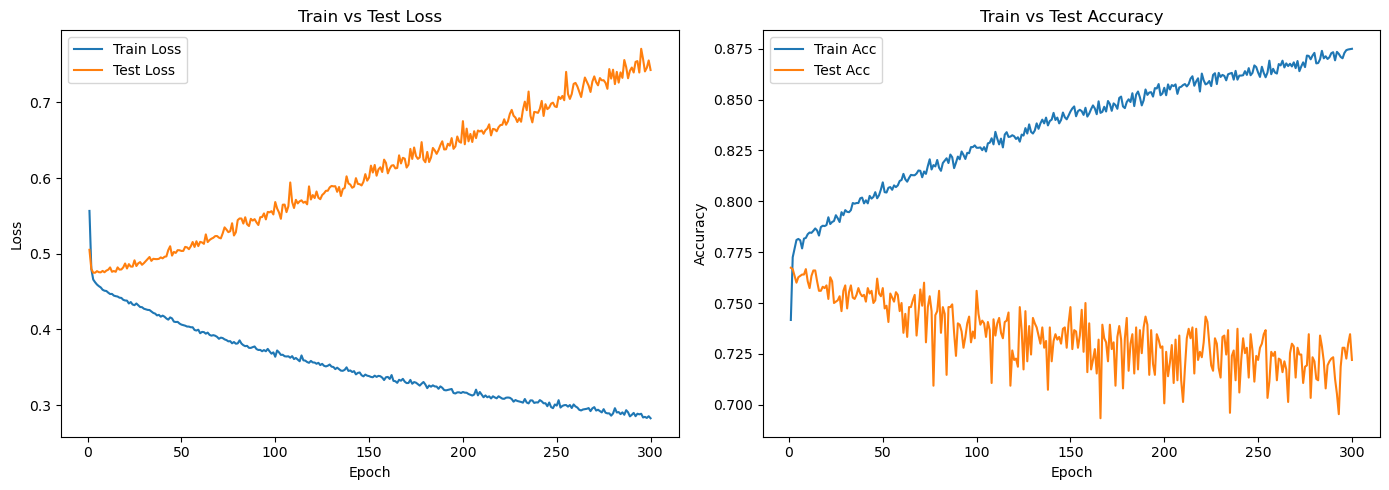

In [14]:
epochs = range(1, num_epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, train_losses, label='Train Loss')
axes[0].plot(epochs, test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train vs Test Loss')
axes[0].legend()

axes[1].plot(epochs, train_accuracies, label='Train Acc')
axes[1].plot(epochs, test_accuracies, label='Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train vs Test Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

可以看到，模型在测试集上的表现极差。过拟合很严重。接下来，我们来尝试使用Dropout来减缓过拟合。

In [15]:
# 使用 Dropout + L2 正则重新训练，缓解过拟合
set_seed(42)  # 确保第二次实验也可复现

drop_model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
).to(device)

weight_decay = 1e-4
drop_optimizer = optim.Adam(drop_model.parameters(), lr=1e-3, weight_decay=weight_decay)

drop_epochs = 200
drop_train_losses, drop_test_losses = [], []
drop_train_accs, drop_test_accs = [], []

for epoch in range(1, drop_epochs + 1):
    drop_model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=pin_memory)
        yb = yb.to(device, non_blocking=pin_memory)
        drop_optimizer.zero_grad()
        logits = drop_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        drop_optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) > 0.5).int()
        running_correct += (preds == yb.int()).sum().item()
        total += xb.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total
    drop_train_losses.append(train_loss)
    drop_train_accs.append(train_acc)

    drop_model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=pin_memory)
            yb = yb.to(device, non_blocking=pin_memory)
            logits = drop_model(xb)
            loss = criterion(logits, yb)
            test_loss += loss.item() * xb.size(0)
            preds = (torch.sigmoid(logits) > 0.5).int()
            test_correct += (preds == yb.int()).sum().item()
            total_test += xb.size(0)

    avg_test_loss = test_loss / total_test
    avg_test_acc = test_correct / total_test
    drop_test_losses.append(avg_test_loss)
    drop_test_accs.append(avg_test_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(f'Dropout Epoch [{epoch:03d}/{drop_epochs}] | ' 
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | ' 
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}')

print(f'Final Test Accuracy with Dropout/L2: {drop_test_accs[-1]:.4f}')

Dropout Epoch [001/200] | Train Loss: 0.5564, Train Acc: 0.7473 | Test Loss: 0.4935, Test Acc: 0.7667
Dropout Epoch [020/200] | Train Loss: 0.4507, Train Acc: 0.7858 | Test Loss: 0.4711, Test Acc: 0.7647
Dropout Epoch [040/200] | Train Loss: 0.4392, Train Acc: 0.7872 | Test Loss: 0.4743, Test Acc: 0.7620
Dropout Epoch [060/200] | Train Loss: 0.4284, Train Acc: 0.7978 | Test Loss: 0.4817, Test Acc: 0.7593
Dropout Epoch [080/200] | Train Loss: 0.4182, Train Acc: 0.8008 | Test Loss: 0.4826, Test Acc: 0.7553
Dropout Epoch [100/200] | Train Loss: 0.4133, Train Acc: 0.8065 | Test Loss: 0.4929, Test Acc: 0.7547
Dropout Epoch [120/200] | Train Loss: 0.4085, Train Acc: 0.8067 | Test Loss: 0.4951, Test Acc: 0.7533
Dropout Epoch [140/200] | Train Loss: 0.3974, Train Acc: 0.8135 | Test Loss: 0.5040, Test Acc: 0.7580
Dropout Epoch [160/200] | Train Loss: 0.3925, Train Acc: 0.8173 | Test Loss: 0.5158, Test Acc: 0.7533
Dropout Epoch [180/200] | Train Loss: 0.3872, Train Acc: 0.8178 | Test Loss: 0.523

### Dropout 模型表现
再绘制一次损失/准确率曲线，观察正则化后的收敛情况。

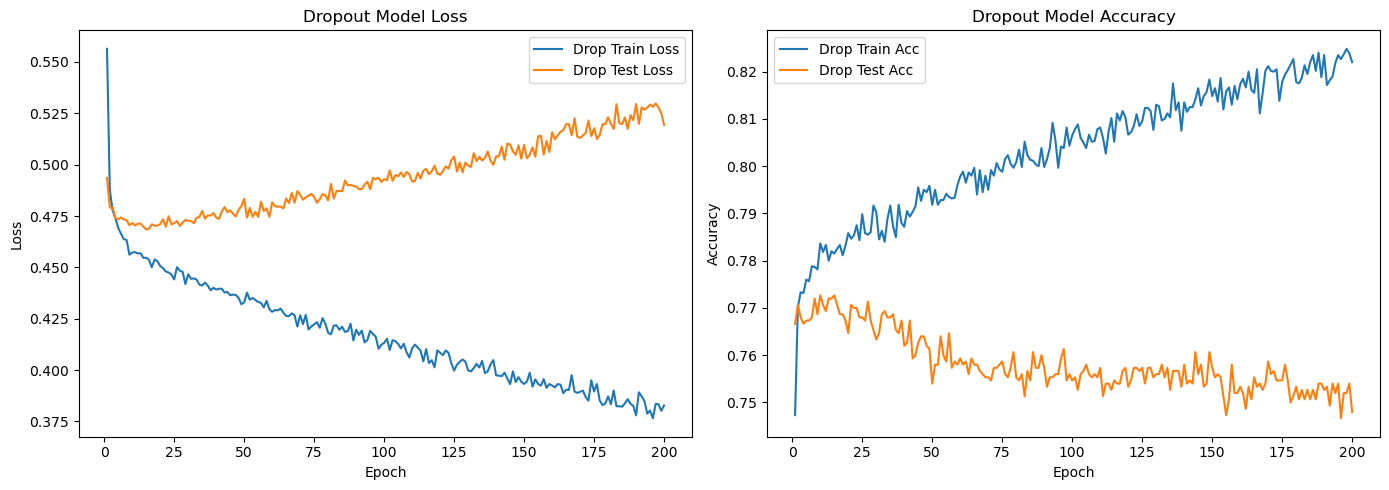

In [16]:
drop_epochs_range = range(1, drop_epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(drop_epochs_range, drop_train_losses, label='Drop Train Loss')
axes[0].plot(drop_epochs_range, drop_test_losses, label='Drop Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Dropout Model Loss')
axes[0].legend()

axes[1].plot(drop_epochs_range, drop_train_accs, label='Drop Train Acc')
axes[1].plot(drop_epochs_range, drop_test_accs, label='Drop Test Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Dropout Model Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## 小结
- 我天，效果更差了。(ㄒ o ㄒ)
- 第一阶段模型有明显的过拟合迹象，因此又用 Dropout + L2 重新训练，记录了第二组损失/准确率曲线。结果效果更差了(｡ŏ﹏ŏ)。本人才疏学浅，先这样吧，之后再来研究一下是为啥吧。
- 之后继续在正则化、网络深度、学习率调度或早停等方向尝试。